In [1]:
import RunFullMap
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps




Using TensorFlow backend.


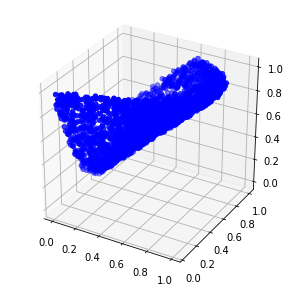

In [2]:
polycurve = PolynomialPointCurve(seed=3142, dimension=3, avg_dims_per_term=1, avg_power_per_dim=2, num_terms=3, avg_mono_term_power=1, max_coeff=2)
#3141 is a good seed
polycurve.compute_threshold(.05)
data = polycurve.gen_noisy_points(3000)
fig=plt.figure(figsize=(5,5))
a1=fig.add_subplot(111, projection='3d')
a1.scatter(data[:,0], data[:,1], data[:,2], color='blue')
plt.show()

In [3]:
data = polycurve.gen_noisy_points(3000)

In [4]:
T_THRESH = 2000
train = data[:T_THRESH]
test = data[T_THRESH:]

In [5]:
def graph_train_test(pred_net, train, test, pos_weight=1):
    fig = plt.figure(figsize=(10,5))
    train_pred = pred_net.predict(train)
    test_pred = pred_net.predict(test)
    a1 = fig.add_subplot(121, projection='3d')
    #a1.scatter(train[:,0], train[:,1],train[:,2], color='blue')
    a1.scatter(train_pred[:,0], train_pred[:,1],train_pred[:,2], color='red')
    a1.set_title('Train data')
    a2 = fig.add_subplot(122, projection='3d')
    #a2.scatter(test[:,0], test[:,1], test[:,2], color='blue')
    a2.scatter(test_pred[:,0], test_pred[:,1], test_pred[:,2], color='red')
    a2.set_title('Test data')
    print ("Train: Original error " + str(polycurve.compute_error(train, orig_points = train, positional_error_coeff=pos_weight)) 
       + " , Test error " + str(polycurve.compute_error(train_pred, orig_points = train, positional_error_coeff=pos_weight)))
    print ("Test: Original error " + str(polycurve.compute_error(test, orig_points = test, positional_error_coeff=pos_weight)) 
       + " , Test error " + str(polycurve.compute_error(test_pred, orig_points = test, positional_error_coeff=pos_weight)))

Gpu available:  True


W0412 13:16:13.612974 139677025548096 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0412 13:16:13.613754 139677025548096 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0412 13:16:13.615280 139677025548096 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0412 13:16:13.626292 139677025548096 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0412 13:16:13.6

Done embedding
Done encoder
Done decoder


W0412 13:16:35.353745 139677025548096 deprecation_wrapper.py:119] From /home/stephen/Desktop/diffusion_net/RunFullMap.py:164: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Original method:
Train: Original error 0.06057116195139279 , Test error 0.07068171099979519
Test: Original error 0.06137190167865664 , Test error 0.07894875037886878


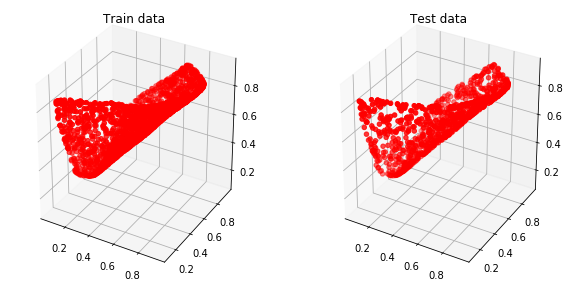

In [6]:
norm_net = RunFullMap.DiffusionNet(train, 2, embedding='normal', visual=False)
print("Original method:")
graph_train_test(norm_net, train, test, pos_weight=2)

In [ ]:
pow_net = RunFullMap.DiffusionNet(train, 2, embedding='pow_ev', eig_power=.5, visual=False)
print("Square eigenvalue method")
graph_train_test(pow_net, train, test, pos_weight=2)

Gpu available:  True
Using power embedding
Done embedding
Done encoder
Done decoder


Gpu available:  True
Using laplacian embedding
[358.73020146 344.14434521]
Done embedding
Done encoder
Done decoder
Laplacian method:
Train: Original error 0.06057116195139279 , Test error 243.2949212579158
Test: Original error 0.06137190167865664 , Test error 251.81350110144894


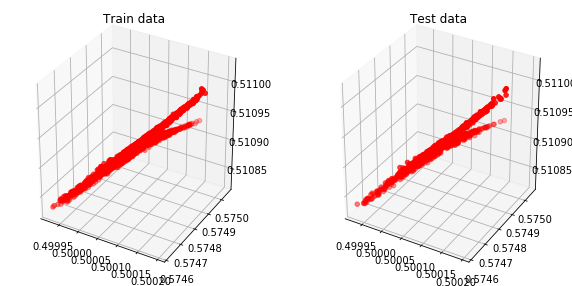

In [8]:
lap_net = RunFullMap.DiffusionNet(train, 2, embedding='laplacian', visual=False)
print("Laplacian method:")
graph_train_test(lap_net, train, test, pos_weight=2)